# Описание задания

В рамках данного задания, студент должен создать и оценить 4 типа рекомендательных систем:
* Non-personalized RS
* Content-based RS
* Item-based collaborative filtering RS
* Hybrid RS

Каждая рекомендательная система - отдельное подзадание. Подзадание считается выполненным, если студент создал рекомендательную систему, которая **лучше (или хуже, но не более чем на 10%)** системы, созданной автором данного блокнота. Системы оцениваются с использованием метрики ``HR@N``, описанной ниже.

# Детальное описание

#### Данные: 
Датасет представлен множеством отзывов к компьютерным играм (объектам) от пользователей Amazon. Каждый отзыв представлен в виде JSON-структуры со следующими полями:
* идентификатор пользователя - reviewerID
* идентификатор объекта - asin
* текст отзыва - reviewText
* рейтинг - overall
* время публикации обзора - unixReviewTime
* другие поля, не использованные автором этого блокнота (смотри полное описание JSON [тут](http://jmcauley.ucsd.edu/data/amazon/))

У каждого объекта есть как минимум 5 отзывов, каждый пользователь написал как минимум 5 отзывов. 
#### Цель: 
Построить рекомендательную систему, предсказывающую объекты, которые пользователь приобретет в ближайшем будущем. Для упрощения мы считаем, что пользователь приобрел объект, если он написал про него отзыв.
#### Подготовка данных:
Данные разделены на тренировочную и тестовую выборки по времени публикации отзывов. Первые 80% данных (более старые) используются как тренировочная выборка, остальные - как тестовая. 

Построение рекомендательной системы (т.е., выбор и тренировка моделей, оптимизация параметров и т.д.) осуществляется **только** с использованием тренировочной выборки. Все параметры, использованные в моделях, **должны быть** получены или объяснены с помощью тренировочных данных. Студент вправе использовать тренировочную выборку как его душе угодно. 

Тестирующая выборка используется **только** для оценки рекомендательной системы.

Для построения рекомендательных моделей также можно использовать JSON-поля из датасета, неиспользованные автором этого блокнота.
#### Оценка качества рекомендательной системы
Цель рекомендательной системы - посоветовать пользователю объекты, которые он захочет приобрести. Для оценки качества такой системы мы воспользуемся метрикой `hit-ratio (HR)`. 

$$
HR = \frac{1}{|U_T|}\sum_{u \in U_T} \mathrm{I}(Rel_u \cap Rec_u)
$$

* $U_T$ - множество пользователей из тестовой выборки
* $Rec_u$ - множество объектов, рекомендованных пользователю $u$ 
* $Rel_u$ - множество объектов, оцененных пользователем $u$ в тестовой выборке
* $\mathrm{I}(Rel_u \cap Rec_u)$ - бинарная функция-индикатор. Функция возвращает 1 если $Rel_u \cap Rec_u \ne \emptyset$, иначе 0

$HR=1$ если для каждого пользователя мы рекомендовали хотя бы один релевантный объект. Так как обычно пользователи просматривают только первые $N$ рекомендаций, мы будем считать метрику $HR@N$, где $N=10$ (т.е. множество $Rec_u$ будет содержать только 10 объектов). 

# Условные обозначения
* `uid` - идентификатор пользователя
* `iid` - идентификатор объекта

# Games RSs

In [2]:
# импорты, которые точно понадобятся
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Данные взяты отсюда - http://jmcauley.ucsd.edu/data/amazon/
# http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz
JSON_DATA_PATH = "Video_Games_5.json"
N = 10

## Анализ данных

In [4]:
import json
import time
from datetime import datetime


def iter_json_data(path):
    with open(path) as f:
        for line in f:
            data = json.loads(line)
            yield data
            
def get_data_frame():
    uid_to_id = {}
    iid_to_id = {}
    
    cols = ["uid", "iid", "review", "rating", "dt", "dtn"]
    rows = []
    for d in iter_json_data(JSON_DATA_PATH):
        uid = uid_to_id.setdefault(d["reviewerID"], len(uid_to_id))
        iid = iid_to_id.setdefault(d["asin"], len(iid_to_id))
        review = d["reviewText"]
        rating = float(d["overall"])
        dt = int(d["unixReviewTime"])
        dtn = datetime.fromtimestamp(d["unixReviewTime"])
        rows.append((uid, iid, review, rating, dt, dtn))
        
    return pd.DataFrame(rows, columns=cols)

In [5]:
df = get_data_frame()
df.head()

,uid,iid,review,rating,dt,dtn
0,0,0,Installing the game was a struggle (because of...,1.0,1341792000,2012-07-09 03:00:00
1,1,0,If you like rally cars get this game you will ...,4.0,1372550400,2013-06-30 03:00:00
2,2,0,1st shipment received a book instead of the ga...,1.0,1403913600,2014-06-28 03:00:00
3,3,0,"I got this version instead of the PS3 version,...",3.0,1315958400,2011-09-14 03:00:00
4,4,0,I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0,1308009600,2011-06-14 03:00:00


In [6]:
print("min-max количество объектов на пользователя:", 
      df.groupby("uid").iid.nunique().min(), df.groupby("uid").iid.nunique().max())
print("min-max количество пользователей на объект:", 
      df.groupby("iid").uid.nunique().min(), df.groupby("iid").uid.nunique().max())

min-max количество объектов на пользователя: 5 773
min-max количество пользователей на объект: 5 802


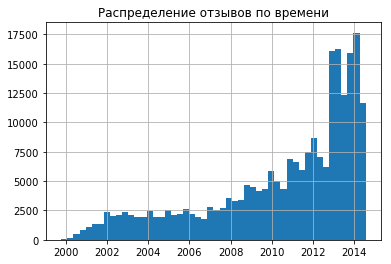

In [7]:
plt.title("Распределение отзывов по времени")
df.dtn.hist(bins=50)

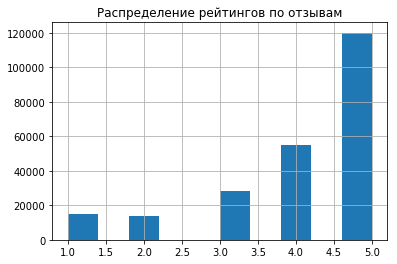

In [8]:
plt.title("Распределение рейтингов по отзывам")
df.rating.hist()

In [9]:
# проверяем, есть ли случаи, когда один и тот же пользователь оставляет отзывы на один и тот же объект
df.groupby(["uid", "iid"]).review.count().unique()  # ура, таких случаев нет

array([1], dtype=int64)

In [10]:
print("Количество объектов:", df.iid.unique().size)
print("Количество пользователей:", df.uid.unique().size)

Количество объектов: 10672
Количество пользователей: 24303


## Готовим выборки

In [11]:
def split_df_by_dt(df, p=0.8):
    """Функция разбивает df на тестовую и тренировочную выборки по времени 
    публикации отзывов (значение времени в поле dt)
    
    :param p: персентиль значений dt, которые образуют тренировочную выборку. Например p=0.8 означает, что в 
    тренировочной части будут отзывы, соответствующие первым 80% временного интервала 
    :return: два pd.DataFrame объекта
    """
    border_dt = df.dt.quantile(p)
    print("Min=%s, border=%s, max=%s" % (df.dt.min(), border_dt, df.dt.max()))
    training_df, test_df  = df[df.dt <= border_dt], df[df.dt > border_dt]
    print("Размер до очистки:", training_df.shape, test_df.shape)
    # удаляем из тестовых данных строки, соответствующие пользователям или объектам, 
    # которых нет в тренировочных данных 
    # (пользователи - избегаем проблем для персональных систем, объекты - для всех)
    test_df = test_df[test_df.uid.isin(training_df.uid) & test_df.iid.isin(training_df.iid)]
    print("Размер после очистки:", training_df.shape, test_df.shape)
    return training_df, test_df

In [12]:
training_df, test_df = split_df_by_dt(df)
del df

Min=939859200, border=1377129600.0, max=1405987200
Размер до очистки: (185427, 6) (46353, 6)
Размер после очистки: (185427, 6) (19174, 6)


In [13]:
def clean_df(df, min_review_per_uid, min_review_per_iid):
    """Функция удаляет из df строки, соответствующие пользователям и объектам, 
    у которых меньше min_review_per_uid и min_review_per_iid отзывов соответственно
    """
    _df = df.copy()
    while True:
        review_per_uid = _df.groupby("uid").review.count()
        bad_uids = review_per_uid[review_per_uid < min_review_per_uid].index
    
        review_per_iid = _df.groupby("iid").review.count()
        bad_iids = review_per_iid[review_per_iid < min_review_per_iid].index
        
        if bad_uids.shape[0] > 0 or bad_iids.shape[0] > 0:
            _df = _df[(~_df.uid.isin(bad_uids)) & (~_df.iid.isin(bad_iids))]
        else:
            break
    return _df

 ## Метрика

Для упрощения тестирования предлагается использовать словарь следующего типа:

```python
recs = {
    uid_1: {
        iid_1: score_11,
        iid_2: score_12,
        ...
    },
    uid_2: {
        iid_1: score_21,
        iid_2: score_22,
        ...
    },
    ...
}
```

где `uid_i` - идентификатор тестового пользователя, `iid_j` - идентификатор рекомендованного объекта, а `score_ij` - предсказанный рейтинг/вес объекта `j` для пользователя `i`.

In [14]:
def hit_ratio(recs_dict, test_dict):
    """Функция считает метрику hit-ration для двух словарей
    :recs_dict: словарь рекомендаций типа {uid: {iid: score, ...}, ...}
    :test_dict: тестовый словарь типа {uid: {iid: score, ...}, ...}
    """
    hits = 0
    for uid in test_dict:
        if set(test_dict[uid].keys()).intersection(recs_dict.get(uid, {})):
            hits += 1
    return hits / len(test_dict)

In [15]:
def get_test_dict(test_df):
    """Функция, конвертирующая тестовый df в словарь
    """
    test_dict = {}
    for t in test_df.itertuples():
        test_dict.setdefault(t.uid, {})
        test_dict[t.uid][t.iid] = t.rating
    return test_dict

test_dict = get_test_dict(test_df)

In [16]:
class BasicRecommender(object):
    def __init__(self):
        pass
    
    def get_recs(self, uid, top):
        """Строит рекомендации для пользователя uid
        :return: словарь типа {iid: score, ...}
        """
        return {}
    
    def get_batch_recs(self, uids, top):
        """Строит рекомендации для нескольких пользователей uids
        :return: словарь типа {uid: {iid: score, ...}, ...}
        """
        return {uid: self.get_recs(uid, top) for uid in uids}

## Content-based RS

Простая content-based рекомендательная система описывает пользователей и объекты как вектора в некотором N-мерном пространстве фич. Вектор объекта показывает, насколько объект принадлежит к той или иной фиче. Вектор пользователя показывает, насколько пользователь предпочитает ту или иную фичу. Рекомендации строятся путем поиска объектов, чьи вектора похожи на вектор предпочтений пользователя. Предполагается, что чем более похожи вектора пользователя и объекта, тем интереснее этот объект пользователю.

#### `HR@10` для content-based, модели созданной автором блокнота: 0.065

# Решение
Для решения используется стандартный шаблон, с некоторыми отличиями:
1. При перемножении фичей, полученных по tfidf на значения рейтингов, используются не рейтинги, а значения рейтингов, умноженные на коэффициент затухания, который зависит от возраста отзыва: чем старше отзыв, тем меньше ценность рейтинга
2. При вычислении профилей пользователей значения фич профиля не умножаются на рейтинги
3. Из выборки исключаются игры, на которые пользователь уже оставил отзыв

In [56]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from scipy.sparse import vstack
from scipy.sparse import csr_matrix
from datetime import datetime

datetime_format = '%d.%m.%Y %H:%M:%S'

class ContentBasedRecommender(BasicRecommender):
    def __init__(self, df, edge_date, verbose=False):
        super(BasicRecommender, self).__init__()

        self._edge_date = time.mktime(edge_date.timetuple())
        self._df = df
        self._max_dt = self._df['dt'].max()
        self._verbose = verbose
        
        self._prepare_recs()
    
    def _prepare_recs(self):
        # формируем новый рейтинг с учетом затухания
        self._df['t_rating'] = self._get_t_rating()
        
        # формируем фичи
        self._tfidf = self._get_tfidf()
        
        # умножаем фичи на приведенные рейтинги
        self._tfidf = self._tfidf.multiply(self._df.t_rating.values.reshape(-1, 1)).tocsr()        
        
        # формируем фичи по играм
        self._iid_to_rowid, self._rowid_to_iid, self._item_features = self._get_item_features()
        
        # формируем профили пользователей
        self._uid_to_row_id, self._user_profiles = self._get_user_profiles()
        
        # формируем словарь того, что юзеры уже посмотрели
        self._watched_dict = self._get_watched_dict()
        
        # транспонируем фичи по играм для быстрого перемножения
        self._features_item = self._item_features.T.tocsr()
        
    def _get_t_rating(self):
        datetime_start = datetime.now()
        if self._verbose:
            print('Начало формирования нового рейтинга:', datetime_start.strftime(datetime_format))
        res = self._df.apply(lambda row: self._decay(row), axis=1);
        if self._verbose:
            print('Новый рейтинг сформирован. Времени затрачено:', (datetime.now() - datetime_start).total_seconds(), 'сек')
        return res
    
    def _decay(self, row):
        r = row['rating']
        dt = row['dt'] - self._edge_date

        coef = dt/self._max_dt

        return r*(0 if dt <= 0 else coef)

    def _get_tfidf(self):
        datetime_start = datetime.now()
        if self._verbose:
            print('Начало формирования tfidf:', datetime_start.strftime(datetime_format))
        res = TfidfVectorizer(stop_words='english').fit_transform(self._df.review)
        if self._verbose:
            print('tfidf сформирован. Времени затрачено:', (datetime.now() - datetime_start).total_seconds(), 'сек')
        return res
    
    def _get_item_features(self):
        iid_to_id = {}
        id_to_iid = {}

        item_features = []

        datetime_start = datetime.now()
        datetime_previous = datetime_start

        iids_unique = self._df.iid.unique()
        total_items = len(iids_unique)

        if self._verbose:
            print('Начало вычисления фичей для игр:', datetime_start.strftime(datetime_format), '. Количество игр:', total_items)

        r_id = 0;
        for row_id, iid in enumerate(iids_unique):
            iid_to_id[iid] = row_id
            id_to_iid[row_id] = iid

            item_features.append(csr_matrix(self._tfidf[np.where(self._df.iid == iid)].sum(axis=0)))

            r_id +=1
            if self._verbose & ((r_id % 1000 == 0) | (r_id % total_items == 0)):
                print('Обработано игр:', r_id, '. Затрачено времени:', (datetime.now() - datetime_previous).total_seconds())
                datetime_previous = datetime.now()

        if self._verbose:            
            print('Вычисление фичей для игр завершено:', datetime_start, '. Затрачено времени:',\
                (datetime.now() - datetime_start).total_seconds())

        return iid_to_id, id_to_iid, normalize(vstack(item_features, format='csr'))    
    
    def _get_user_profiles(self):
        uid_to_row_id = {}
        user_profiles = []

        datetime_start = datetime.now()
        datetime_previous = datetime_start

        grouped_by_uid = self._df.groupby('uid')
        total_users = len(grouped_by_uid)

        if self._verbose:
            print('Начало вычисления профилей пользователей:', datetime_start, '. Количество пользователей:', total_users)

        r_id = 0;
        for gr_id, gr_df in grouped_by_uid:
            uid = gr_df.uid.values[0];

            item_ids = []
            for iid, rating in zip(gr_df.iid, gr_df.rating):
                item_ftr_id = self._iid_to_rowid[iid]
                item_ids.append(item_ftr_id)

            if (item_ids):
                uid_to_row_id[uid] = len(uid_to_row_id)
                profile = csr_matrix(
                        self._item_features[item_ids].sum(axis=0)
                    ) 
                user_profiles.append(profile)

            r_id +=1;
            if self._verbose & ((r_id % 2000 == 0) | (r_id % total_users == 0)):
                print('Обработано пользователей:', r_id, '. Затрачено времени:', (datetime.now() - datetime_previous).total_seconds())
                datetime_previous = datetime.now()

        if self._verbose:
            print('Вычисление профилей пользователей завершено:', datetime_start, '. Затрачено времени:',\
                (datetime.now() - datetime_start).total_seconds())

        return uid_to_row_id, normalize(vstack(user_profiles, format='csr'))    
    
    def _get_watched_dict(self):
        watched_dict = {}
        for gr_id, gr_df in self._df[['uid', 'iid']].groupby('uid'):
            uid = gr_df['uid'].values[0]

            iids = []
            for iid in gr_df.iid:
                iids.append(iid)

            watched_dict[uid] = iids
        return watched_dict
    
    def get_recs(self, uid, top):
        recs = {}
        
        if uid not in self._uid_to_row_id:
            return recs
    
        row_id = self._uid_to_row_id[uid]
        u_row = self._user_profiles[row_id]

        u_recs = u_row.dot(self._features_item)

        played_iids = self._watched_dict[uid]

        for arg_id in np.argsort(u_recs.data)[-top-len(played_iids):]:
            row_id = u_recs.indices[arg_id]
            iid = self._rowid_to_iid[row_id]
            if iid not in played_iids:
                score = u_recs.data[arg_id]
                recs[self._rowid_to_iid[row_id]] = score
                if len(recs) >= top:
                    break
        return recs
    
    def get_batch_recs(self, uids, top):
        datetime_start = datetime.now()
        datetime_previous = datetime_start

        total_users = len(uids)

        recs = {}
        if self._verbose:
            print('Начало получения рекоммендаций: ', datetime_previous, '. Количество пользователей:', total_users)

        row_id = 0
        for uid in uids:

            recs[uid] = self.get_recs(uid, top)
            row_id += 1
            if self._verbose & ((row_id % 2000 == 0) | (row_id % total_users == 0)):
                print('Обработано пользователей:', row_id, '. Затрачено:', \
                      (datetime.now()-datetime_previous).total_seconds(), 'сек.')
                datetime_previous = datetime.now()

        if self._verbose:
            print('Получение рекоммендаций завершено:', datetime.now(), \
                  '. Всего затрачено времени:', (datetime.now() - datetime_start).total_seconds())        
        return recs


In [42]:
testdict = get_test_dict(test_df)
uiids = list(testdict.keys())
rs = ContentBasedRecommender(training_df, datetime(2007, 1, 1)) # дата выбрана случайно. на кросс-валидацию не хватило времени.

Начало формирования нового рейтинга: 20.08.2017 23:04:51
Новый рейтинг сформирован. Времени затрачено: 20.719831 сек
Начало формирования tfidf: 20.08.2017 23:05:12
tfidf сформирован. Времени затрачено: 34.786422 сек
Начало вычисления фичей для игр: 20.08.2017 23:05:51 . Количество игр: 10098
Обработано игр: 1000 . Затрачено времени: 4.454678
Обработано игр: 2000 . Затрачено времени: 4.404715
Обработано игр: 3000 . Затрачено времени: 4.298784
Обработано игр: 4000 . Затрачено времени: 4.267445
Обработано игр: 5000 . Затрачено времени: 4.390725
Обработано игр: 6000 . Затрачено времени: 4.268729
Обработано игр: 7000 . Затрачено времени: 4.271758
Обработано игр: 8000 . Затрачено времени: 4.278095
Обработано игр: 9000 . Затрачено времени: 4.461078
Обработано игр: 10000 . Затрачено времени: 4.471824
Обработано игр: 10098 . Затрачено времени: 0.420103
Вычисление фичей для игр завершено: 2017-08-20 23:05:51.205009 . Затрачено времени: 43.990935
Начало вычисления профилей пользователей: 2017-08-

In [43]:
hit_ratio(rs.get_batch_recs(uiids, 10), testdict)

Начало получения рекоммендаций:  2017-08-20 23:08:27.858867 . Количество пользователей: 6815
Обработано пользователей: 2000 . Затрачено: 18.951717 сек.
Обработано пользователей: 4000 . Затрачено: 19.82847 сек.
Обработано пользователей: 6000 . Затрачено: 21.054393 сек.
Обработано пользователей: 6815 . Затрачено: 8.823032 сек.
Получение рекоммендаций завершено: 2017-08-20 23:09:36.517980 . Всего затрачено времени: 68.659113


0.07043286867204696

##### HR@10 получился 0.0704